 ### Problem
 
Generate a galaxy (exponential profile, r_eff=0.3", 50deg inclination), with integrated magnitude K_AB=24. Put a few point sources (globular cluster progenitors) around it with magnitudes in the range 
K_AB=26-28mag.
 
Set DIT=20sec and NDIT=6 (might need to increase this to see anything). 

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

import numpy as np
from astropy.wcs import WCS
import astropy.units as u

import scopesim as sim
import scopesim_templates as sim_tp

In [2]:
# Utility functions to calculate ellipticity from the inclination and vice versa

def inclination2ellipticity(inclination, q=0.2):
    """
    calculate galaxy ellipticity from the inclination (in degrees!)
    q is the true axis ratio with default q=0.2 as in Heidmann 1972
    """
    i = np.deg2rad(inclination)
    btoa = np.sqrt((1 - q**2) * np.cos(i)**2 + q**2)
    ell = 1 - btoa
    return ell

def ellipticity2inclination(ellipticity, q=0.2):
    """
    calculate galaxy inclination (in degrees) from the ellipticity measured on images
    q is the true axis ratio with default q=0.2 as in Heidmann 1972
    """
    btoa = 1 - ellipticity
    i =  np.arccos(np.sqrt( (btoa**2 - q**2)/(1 - q**2) ))
    inclination = np.rad2deg(i)
    return inclination36

We first create the source according to the required parameters. Any SED and filter available in [speXtra](https://spextra.readthedocs.io/en/latest/) is available here. It is important to make sure that the filters (including the observing one) and spectrum overlap. 

The filter provided is where the magnitude/flux is measured, not the observing filter. 

Similarly the plate_scale doesn't refere to the instrumental plate scale, but the scale of the source image. Having similar or sligthly higher resolution is recomended to avoid undersampling. 



In [3]:
magAB = 22 * u.ABmag            # magnitude
r_eff = 0.3 * u.arcsec           # effective radius
n = 1                           # sersic index for a disk galaxy
inclination = 50                # inclination
sed = "brown/NGC4387"           # speXtra SED
filter_curve = "K"              # speXtra filters
plate_scale = 0.004 * u.arcsec  # plate scale of the source image
z = 3                           # redshift
extend = 10                     # The extend of the source image in units of r_eff

ellipticity = inclination2ellipticity(inclination)

# analytical galaxy source with the parameters
src1 = sim_tp.basic.galaxy.galaxy(sed=sed, mag=magAB, r_eff=r_eff, filter_curve="Ks",
                                  ellip=ellipticity, extend=extend, n=n, plate_scale=plate_scale)

# stellar field
src2 = sim_tp.basic.stars.star_field(n=10, mmin=26*u.mag, mmax=28*u.mag, 
                                     width=1, filter_name="Ks")

src = src1 + src2  # adding the sources

We now do the observations. For that we need to download the proper instrument packages and configure the observations

In [4]:
sim.server.database.download_package(["locations/Armazones.zip",
                                      "telescopes/ELT.zip",
                                      "instruments/MAORY.zip",
                                      "instruments/MICADO.zip",] )

#cmd = sim.UserCommands(use_instrument="MICADO", set_modes=["IMG_4mas"])
#micado = sim.OpticalTrain(cmd)
micado = sim.OpticalTrain("MICADO")
Set
dit = 20
ndit = 6
micado.cmds["!OBS.dit"] = dit                        # dit & ndit
micado.cmds["!OBS.ndit"] = ndit
micado.cmds["!OBS.filter_name"] = "Ks"               # observing filter

micado["detector_window"].include = True             # We observe a window to save time
micado['detector_linearity'].include = False         # Forget about non-linearity for a while

# Observe the source and save it to disk
micado.observe(src)

hdus = micado.readout(filename="globular_clusters.fits")
print("Total exposure time %s seconds" % (dit*ndit))

Preparing 2 FieldOfViews
Total exposure time 120 seconds


5462.978742622115


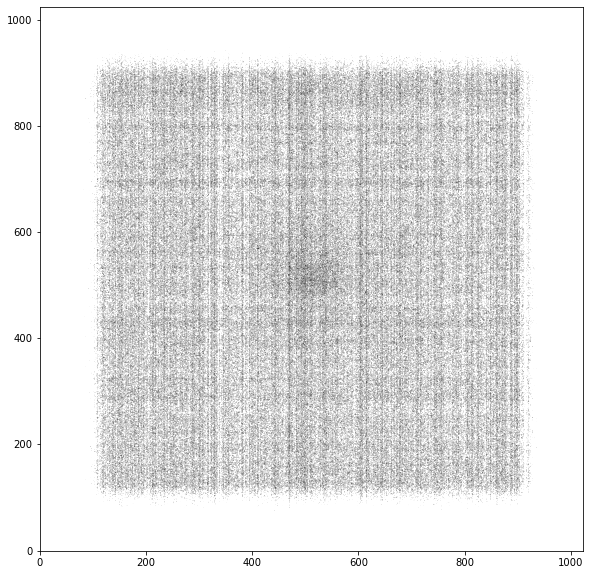

In [5]:
# Some ploting

plt.figure(figsize=(10,10))
data = hdus[0][1].data
print(np.median(data))
data = data #- np.median(data)
vmin = np.median(data)
vmax = vmin + 1*np.std(data)

plt.imshow(data, norm=LogNorm(vmin=vmin, vmax=vmax), origin="lower", cmap="gray_r")


Plainly too short exposure time. Let's increase it. 

In [6]:

dit = 120  # seconds
ndit = 60
micado.cmds["!OBS.dit"] = dit                        # dit & ndit
micado.cmds["!OBS.ndit"] = ndit

# Observe the source and save it to disk
micado.observe(src)

hdus = micado.readout(filename="globular_clusters.fits")

print("Total exposure time %s seconds" % (dit*ndit))

Preparing 2 FieldOfViews
Total exposure time 7200 seconds


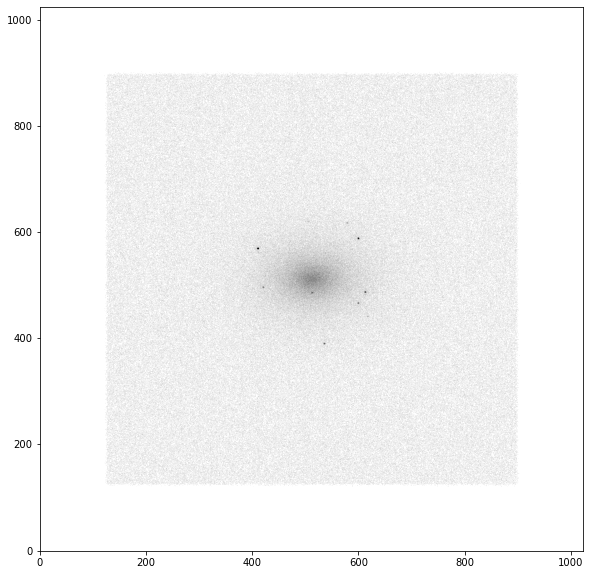

In [10]:
# Some more ploting

plt.figure(figsize=(10,10))
data = hdus[0][1].data

vmin = np.median(data) 
vmax = vmin + 0.5*np.std(data)

plt.imshow(data, vmin=vmin, vmax=vmax, origin="lower", cmap="gray_r")
